# Matched Distribution on resonance

- Start at resonance
- Add a quadrupole to move away from resonance
- Match a distribution
- Track and collapse quad over a few hundred turns
- You should see the ellipse transform into a triangular shape
- Then start SX

``dQ = Beta(at quad)*integrated_strength [m]*[m^-1]``


In [1]:
import xtrack as xt
import xpart as xp
import xobjects as xo

import pybt

import matplotlib.pyplot as plt

import json
from numpy import random
import random
import numpy as np

from cpymad.madx import Madx

import scipy as sp

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Constants

In [2]:
REL_GAMMA = 25.598474067
REL_BETA = np.sqrt(1-REL_GAMMA**(-2))

exn = 1.5e-6
eyn = 1.5e-6
ex = exn/(REL_BETA*REL_GAMMA)
ey = eyn/(REL_BETA*REL_GAMMA)

p = 24 # beam momentum (GeV/c)
momentum = 24 # beam momentum (GeV/c)
Brho = 24*3.3356

PS_radius = 70.079

TUNE_TARGET = 6.2

SEPTA = True

DPP_FACTOR = 1e-3

# Load PS at East Extraction

In [3]:
mad = Madx(stdout=True)

PS_REPO = "../../../../models/acc-models-ps/"

mad.call(PS_REPO+"ps_mu.seq")
mad.call(PS_REPO+"ps_ss.seq")
mad.call(PS_REPO+"scenarios/east/4_slow_extraction/ps_se_east.str")

mad.command.beam(
    particle="PROTON",
    pc = p,
    ex = ex,
    ey = ey
)
mad.input(f"BRHO      := BEAM->PC * 3.3356;")
mad.use(sequence="PS")
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
mad.input('savebeta, label=bumped23, place = PR.BPM23;')


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2023.03.16 14:24:51      +
  ++++++++++++++++++++++++++++++++++++++++++++
/**********************************************************************************

*

* Elements description and sequence file for each PS main unit (MU).

*

* 07/10/2020 - Alexander Huschauer

************************************************************************************/



/************************************************************************************

*

*         DEFINITION OF FOCUSING AND DEFOCUSING HALF-UNITS OF THE MU               

*

*************************************************************************************/



/************************************************************************************

*        							 F HALF-UNITS     					            

***********************

True

# Set PFWs, Cycle & Flatten

In [4]:
mad.use(sequence="PS")
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
mad.input('savebeta, label=bumped23, place = PR.BPM23;')
twiss_initial = mad.twiss().dframe()
len_ps = twiss_initial.s[-1]

mad.input('SEQEDIT, sequence=PS;')
mad.input('FLATTEN;')
mad.command.install(element = 'marker_ss62_end', class_='MARKER', at=0, from_='SS62$END')
mad.command.install(element = 'marker_ss63_start', class_='MARKER', at=0, from_='SS63$START')
mad.input('CYCLE, START=PR.BPM23;') # This will be the place to start the ejection sequence
mad.input('FLATTEN;')
mad.input('ENDEDIT;')

mad.use(sequence = "PS")
twiss_cycled = mad.twiss().dframe()


enter Twiss module
  
iteration:   1 error:   1.819621E-03 deltap:   0.000000E+00
orbit:   2.101246E-03  1.661586E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   2.558824E-05 deltap:   0.000000E+00
orbit:   2.091665E-03  1.667237E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   3 error:   1.003865E-09 deltap:   0.000000E+00
orbit:   2.091665E-03  1.667237E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
          628.3185                 -0      0.02580742276        6.224832674 

                q1                dq1            betxmax              dxmax 
       6.323299708       -1.667504838        32.28796336        4.453762272 

             dxrms             xcomax             xcorms                 q2 
        2.71050399      0.03408032387     0.007371706694        6.218892911 

               dq2            

/opt/homebrew/Caskroom/miniconda/base/envs/cern/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


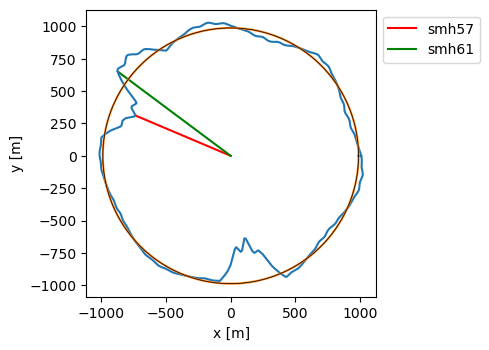

In [5]:
from matplotlib import patches
c = twiss_initial.s[-1]
r = c/2*np.pi

fig, ax = plt.subplots(tight_layout=True, figsize=(5, 5))

x_x = []
x_y = []
for i in range(len(twiss_initial)):
    x = (r+10000*twiss_initial.x[i])*np.cos(twiss_initial.s[i]*2*np.pi/c)
    y = (r+10000*twiss_initial.x[i])*np.sin(-twiss_initial.s[i]*2*np.pi/c) # Clockwise
    x_x.append(x)
    x_y.append(y)

y_x = []
y_y = []
for i in range(len(twiss_initial)):
    x = (r+10000*twiss_initial.y[i])*np.cos(twiss_initial.s[i]*2*np.pi/c)
    y = (r+10000*twiss_initial.y[i])*np.sin(-twiss_initial.s[i]*2*np.pi/c) # Clockwise
    y_x.append(x)
    y_y.append(y)

theta = twiss_initial.s*2*np.pi/c
x = r*np.cos(theta)
y = r*np.sin(theta)

loc_57 = twiss_initial.loc[twiss_initial['name'] == 'pe.smh57:1']['s']
x_57 = (r+10000*twiss_initial.loc[twiss_initial['name'] == 'pe.smh57:1']['x'])*np.cos(loc_57*2*np.pi/c)
y_57 = (r+10000*twiss_initial.loc[twiss_initial['name'] == 'pe.smh57:1']['x'])*np.sin(-loc_57*2*np.pi/c) # Clockwise
# mark 57
ax.plot([0, x_57], [0, y_57], color='red', label='smh57')


loc_61 = twiss_initial.loc[twiss_initial['name'] == 'pe.smh61:1']['s']
x_61 = (r+10000*twiss_initial.loc[twiss_initial['name'] == 'pe.smh61:1']['x'])*np.cos(loc_61*2*np.pi/c)
y_61 = (r+10000*twiss_initial.loc[twiss_initial['name'] == 'pe.smh61:1']['x'])*np.sin(-loc_61*2*np.pi/c) # Clockwise
# mark 61
ax.plot([0, x_61], [0, y_61], color='green', label='smh61')


ax.plot(x_x,x_y)
ax.plot(y_x,y_y)
ax.plot(x, y, color="k", lw=0.5)
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_aspect("equal")
ax.legend()
# legend top right
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

###
---

In [6]:
# Makethin
mad.use(sequence='ps')
mad.select(flag='makethin', class_='rbend', slice_=4)
mad.select(flag='makethin', class_='quadrupole', slice_=4)
mad.select(flag='makethin', class_='sbend', slice_=4)
mad.select(flag='makethin', class_='sextupole', slice_=2)
mad.makethin(sequence='ps')

# Convert to Xtrack
mad.use(sequence="PS")
bare_line = xt.Line.from_madx_sequence(
    mad.sequence()
    )
line = bare_line
#line = bare_line.filter_elements(exclude_types_starting_with='Cavity')

makethin: slicing sequence : ps
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: - kpebsw57 * 1.06492 * pe.bsw57.59->l / pe.bsw57.53->l 
++++++ warning: division by zero, result set to zero, expr: - kpebsw57 * 1.19887 * pe.bsw57.59->l / pe.bsw57.61->l 
++++++ warning: division by zero, result set to zero, expr: + kpebsw57 * 1.06492 * pe.bsw57.59->l / pe.bsw57.67->l 
++++++ warning: division by zero, result set to 

In [7]:
# Create monitors
ctx = xo.ContextCpu()

N_PART = int( 5e3 )
N_TURN = int( 5e2 )

line.particle_ref = xp.Particles(
    mass0=xp.PROTON_MASS_EV,
    q0=1,
    p0c=p*sp.constants.c
)

In [8]:
# xp.generate_matched_gaussian_bunch(
#     num_particles = N_PART,
#     nemitt_x = exn,
#     nemitt_y = eyn,
#     sigma_z = 0,
#     particle_on_co = co,
#     circumference=line.get_length(),
#     momentum_compaction_factor = tw['momentum_compaction_factor'], 
#     tracker=tracker,
#     freeze_longitudinal=True,
# )

enter Twiss module
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * 

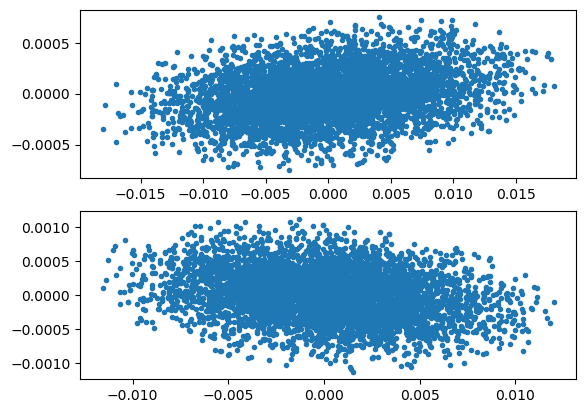

In [9]:
mad_tw = mad.twiss()
# TODO: check eps is normalised emittance
pybt_matched_dist_x = pybt.tools.particles.beam_distrib_norm(
    alpha = mad_tw['alfx'][0],
    beta = mad_tw['betx'][0],
    eps = exn,
    nparts = N_PART,
    nsigma = 3
    
)
pybt_matched_dist_y = pybt.tools.particles.beam_distrib_norm(
    alpha = mad_tw['alfy'][0],
    beta = mad_tw['bety'][0],
    eps = eyn,
    nparts = N_PART,
    nsigma = 3
    
)
pybt_matched_dist_s = pybt.tools.particles.dpp_distrib_norm(
    dpp = 1e-3*DPP_FACTOR,
    nparts = N_PART,
    nsigma = 2
)

fig, ax = plt.subplots(2, 1)
ax[0].plot(pybt_matched_dist_x[:,0], pybt_matched_dist_x[:,1], '.', label='pybt')
ax[1].plot(pybt_matched_dist_y[:,0], pybt_matched_dist_y[:,1], '.', label='pybt')

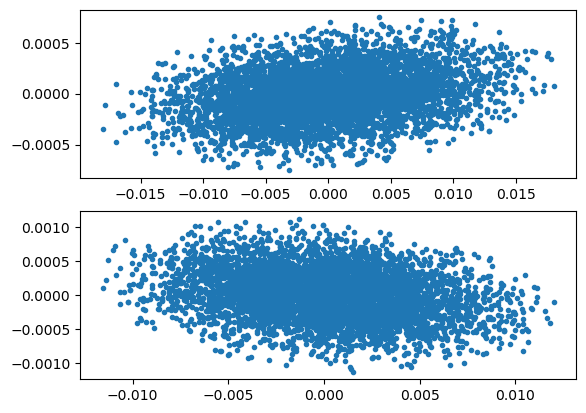

In [10]:
parts_x_disp =  np.array(pybt_matched_dist_x[:,0]) + np.array(mad_tw['dx'][0] * pybt_matched_dist_s)
parts_px_disp = np.array(pybt_matched_dist_x[:,1]) + np.array(mad_tw['dpx'][0] * pybt_matched_dist_s)

parts_y_disp =  np.array(pybt_matched_dist_y[:,0]) + np.array(mad_tw['dy'][0] * pybt_matched_dist_s)
parts_py_disp = np.array(pybt_matched_dist_y[:,1]) + np.array(mad_tw['dpy'][0] * pybt_matched_dist_s)

fig, ax = plt.subplots(2, 1)
ax[0].plot(parts_x_disp, parts_px_disp, '.', label='pybt')
ax[1].plot(parts_y_disp, parts_py_disp, '.', label='pybt')

In [11]:
DETUNE_QUAD_KNL1 = 0

In [12]:
detuning_quad = xt.SimpleThinQuadrupole(
    knl = [0, DETUNE_QUAD_KNL1]
)
line.insert_element(
    element = detuning_quad,
    index = 0,
    name = "DETUNING_QUAD"
)

In [13]:
smh57_monitor = xt.ParticlesMonitor(
    _context = ctx,
    num_particles = N_PART,
    start_at_turn = 0,
    stop_at_turn = N_TURN
)
smh61_monitor = xt.ParticlesMonitor(
    _context = ctx,
    num_particles = N_PART,
    start_at_turn = 0,
    stop_at_turn = N_TURN
)
line.insert_element(
    element = smh57_monitor,
    name = 'SMH57_MONITOR',
    index = 'pe.smh57'
)
line.insert_element(
    element = smh61_monitor,
    name = 'SMH61_MONITOR',
    index = 'pe.smh61'
)

# Perform MAD twiss
mad_twiss = mad.twiss()
mad_twiss_summ = mad_twiss.summary

tracker = line.build_tracker()

parts = tracker.build_particles(
    x =  parts_x_disp,
    px = parts_px_disp,
    y =  parts_y_disp,
    py = parts_py_disp
)

# Track
tunes = []
strengths = []
delta = line['DETUNING_QUAD'].knl[1]/N_TURN
for turn in range(N_TURN):
    cur_strength = line['DETUNING_QUAD'].knl[1]
    line['DETUNING_QUAD'].knl[1] = cur_strength - delta
    tracker.track(parts)
    tune = tracker.twiss(method='4d')['qx']
    tunes.append(tune)
    strengths.append(line['DETUNING_QUAD'].knl[1])

enter Twiss module
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * 

In [14]:
tw = tracker.twiss(method='4d')
print(f"Tune before detune: {mad_tw.summary['q1']}")
print(f"Tune after detune: {tw['qx']}")

Tune before detune: 6.298198522
Tune after detune: 6.298206970198582


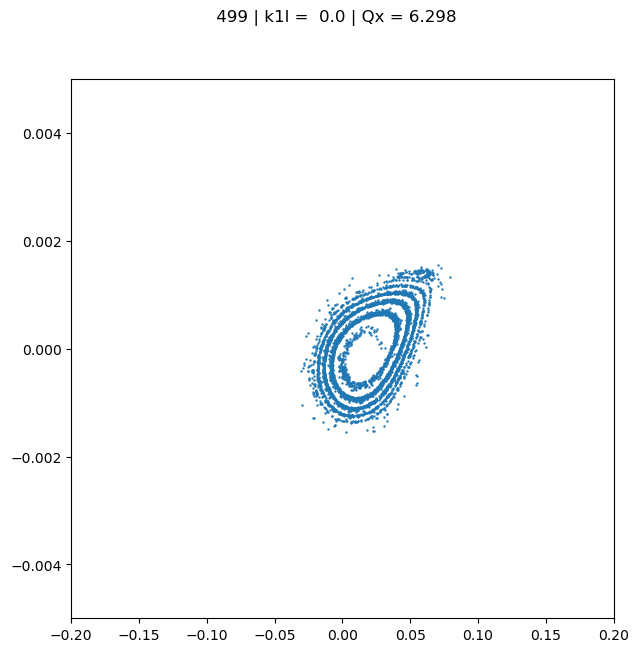

In [15]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots(figsize=(7, 7), tight_layout=False)

def animate(i):
    ax.clear()
    #ax.set_aspect("equal")
    ax.set_xlim(-0.2, 0.2)
    ax.set_ylim(-0.005, 0.005)
    fig.suptitle(f"{i:>4} | k1l = {round(strengths[i], 4):>4} | Qx = {round(tunes[i], 3):>4}")
    try:
        ax.scatter(smh57_monitor.x.T[i], smh57_monitor.px.T[i], marker='.', s=2)
    except:
        print("fail at", i)
        pass
    return
ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=False, frames=N_TURN)
ani.save("quad_collapse.gif", writer=PillowWriter(fps=30))


In [16]:
1/tw['T_rev']

473128.56479373755

In [17]:
test_tw = tracker.twiss(method='4d')